# 0.744 with nerodia classifier

In [1]:
import pandas as pd
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *

In [3]:
torch.cuda.is_available()

True

In [4]:
np.random.seed(42)

In [5]:
tfms = get_transforms(do_flip=True,flip_vert=False,max_rotate=10.0,max_zoom=1.2,max_lighting=0.5,max_warp=0.2,p_affine=0.75,p_lighting=0.75)


In [6]:
mixup=0.2

In [7]:
loss_func = LabelSmoothingCrossEntropy()

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=1.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
focal_loss_func = FocalLoss(gamma=2.)

In [9]:
alpha=0.99
mom=0.9
eps=1e-6

In [10]:
opt_func = partial(optim.Adam, betas=(mom,alpha), eps=eps)

In [11]:
src = (ImageList.from_folder(path='train').split_by_rand_pct(0.2).label_from_folder())

In [12]:
data = src.transform(tfms,size=(640)).databunch(bs=16).normalize()

In [13]:
learn = cnn_learner(data, models.densenet121,pretrained=False, metrics=[error_rate, accuracy, FBeta(beta=1,average='macro')],loss_func = loss_func,opt_func=opt_func,wd=1e-2)

/home/ubuntu/anaconda3/envs/snakes_breed/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
learn= learn.mixup(alpha=mixup)

In [15]:
learn.bn_wd=False

In [16]:
learn.true_wd=True

In [17]:
learn.load('exp-11-round-1')

Learner(data=ImageDataBunch;

Train: LabelList (65934 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-857,class-857,class-857,class-857,class-857
Path: train;

Valid: LabelList (16483 items)
x: ImageList
Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640),Image (3, 640, 640)
y: CategoryList
class-540,class-526,class-771,class-4,class-804
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
src_new = (ImageList.from_folder(path='train',include=["class-390","class-653","class-140","class-67"]).split_by_rand_pct(0.2).label_from_folder())

In [19]:
data_new = src_new.transform(tfms,size=(896)).databunch(bs=12).normalize()

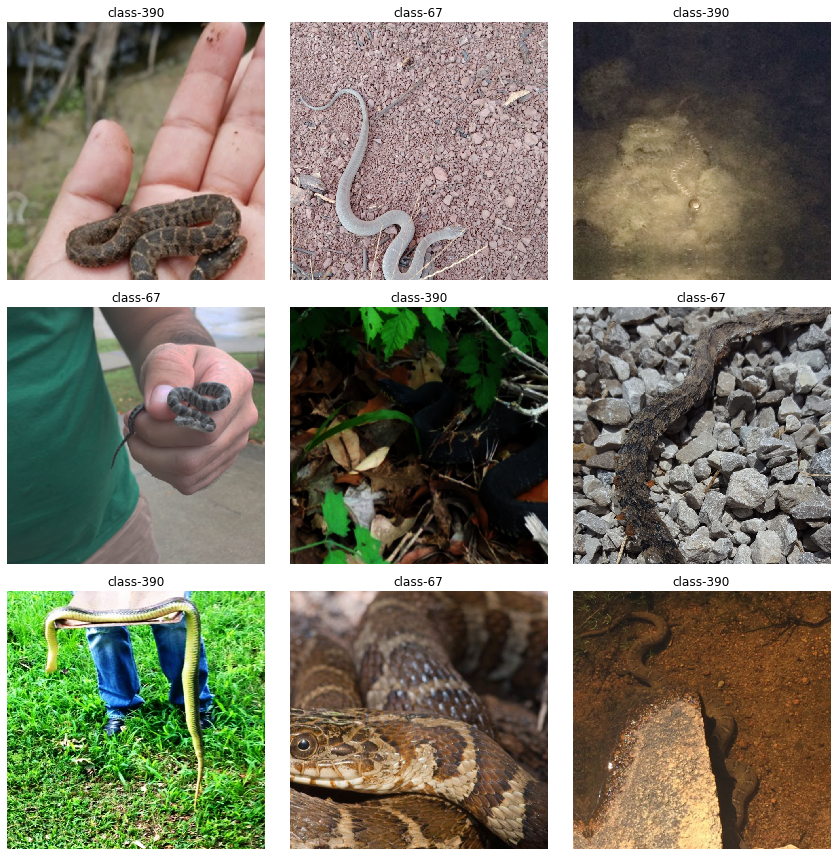

In [20]:
data_new.show_batch(rows=3, figsize=(12,12))

In [21]:
learn.data = data_new

In [22]:
concat_pool=True

In [23]:
nf = num_features_model(nn.Sequential(*learn.model[0].children())) * (2 if concat_pool else 1)

In [24]:
nf

2048

In [25]:
custom_head=create_head(nf, 4, None, ps=0.5, concat_pool=concat_pool, bn_final=False)

In [26]:
learn.model = nn.Sequential(*list(children(learn.model))[:-1], custom_head)

In [27]:
learn.model.cuda()

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_ru

In [28]:
learn = learn.to_fp16(dynamic=True)

In [29]:
learn.load('nerodia-round-2')

Learner(data=ImageDataBunch;

Train: LabelList (6158 items)
x: ImageList
Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896)
y: CategoryList
class-140,class-140,class-140,class-140,class-140
Path: train;

Valid: LabelList (1539 items)
x: ImageList
Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896),Image (3, 896, 896)
y: CategoryList
class-67,class-67,class-67,class-67,class-67
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [30]:
df = pd.read_csv('submission-2.csv',low_memory=False)

In [31]:
df.head()

,filename,agkistrodon_contortrix,agkistrodon_piscivorus,boa_imperator,carphophis_amoenus,charina_bottae,coluber_constrictor,crotalus_adamanteus,crotalus_atrox,crotalus_horridus,...,regina_septemvittata,rhinocheilus_lecontei,storeria_dekayi,storeria_occipitomaculata,thamnophis_elegans,thamnophis_marcianus,thamnophis_ordinoides,thamnophis_proximus,thamnophis_radix,thamnophis_sirtalis
0,e5cf4ff0a9326e1eae50b7b4c6ddff19.jpg,0.001101,0.001290,0.000592,0.012547,0.000688,0.002600,0.000500,0.001253,0.000725,...,0.001283,0.000663,0.002120,0.001215,0.000632,0.000941,0.001305,0.000713,0.000452,0.001553
1,04c26281edbd155dca879084cdf860dc.jpg,0.012227,0.009883,0.006562,0.004459,0.004420,0.004619,0.005584,0.022746,0.023403,...,0.003802,0.009957,0.012157,0.004046,0.003008,0.006691,0.005566,0.006390,0.006932,0.648545
2,703e09e07ef754f4e60b7dfb3cad53bc.jpg,0.002034,0.007905,0.003079,0.001900,0.002189,0.001778,0.000694,0.003173,0.005923,...,0.001826,0.003251,0.006801,0.004201,0.003900,0.002030,0.001398,0.002165,0.001034,0.010624
3,6930489ef4a47b44e717c351b1893019.jpg,0.051632,0.010804,0.010608,0.004762,0.024319,0.010939,0.009692,0.138383,0.019260,...,0.006025,0.016214,0.016145,0.007686,0.007105,0.008815,0.030455,0.006049,0.010626,0.062437
4,790d4ba419acd10b3f27c40abf641686.jpg,0.005229,0.007836,0.010057,0.003692,0.008069,0.008216,0.006193,0.018113,0.004133,...,0.004513,0.004308,0.108470,0.018880,0.209652,0.020386,0.018643,0.005512,0.011422,0.165548


In [32]:
df_new = df.iloc[:,1:46]

In [33]:
df_new.head()

,agkistrodon_contortrix,agkistrodon_piscivorus,boa_imperator,carphophis_amoenus,charina_bottae,coluber_constrictor,crotalus_adamanteus,crotalus_atrox,crotalus_horridus,crotalus_pyrrhus,...,regina_septemvittata,rhinocheilus_lecontei,storeria_dekayi,storeria_occipitomaculata,thamnophis_elegans,thamnophis_marcianus,thamnophis_ordinoides,thamnophis_proximus,thamnophis_radix,thamnophis_sirtalis
0,0.001101,0.001290,0.000592,0.012547,0.000688,0.002600,0.000500,0.001253,0.000725,0.000762,...,0.001283,0.000663,0.002120,0.001215,0.000632,0.000941,0.001305,0.000713,0.000452,0.001553
1,0.012227,0.009883,0.006562,0.004459,0.004420,0.004619,0.005584,0.022746,0.023403,0.008770,...,0.003802,0.009957,0.012157,0.004046,0.003008,0.006691,0.005566,0.006390,0.006932,0.648545
2,0.002034,0.007905,0.003079,0.001900,0.002189,0.001778,0.000694,0.003173,0.005923,0.003229,...,0.001826,0.003251,0.006801,0.004201,0.003900,0.002030,0.001398,0.002165,0.001034,0.010624
3,0.051632,0.010804,0.010608,0.004762,0.024319,0.010939,0.009692,0.138383,0.019260,0.081868,...,0.006025,0.016214,0.016145,0.007686,0.007105,0.008815,0.030455,0.006049,0.010626,0.062437
4,0.005229,0.007836,0.010057,0.003692,0.008069,0.008216,0.006193,0.018113,0.004133,0.009408,...,0.004513,0.004308,0.108470,0.018880,0.209652,0.020386,0.018643,0.005512,0.011422,0.165548


In [34]:
snakes_predicted =df_new.idxmax(axis=1) 

In [35]:
data_new.classes 

['class-140', 'class-390', 'class-653', 'class-67']

In [36]:
df['filename'][0]

'e5cf4ff0a9326e1eae50b7b4c6ddff19.jpg'

In [37]:
from pathlib import Path

In [38]:
TEST_PATH = Path(r'/home/ubuntu/snakes_breed/round1')

In [39]:
img_name = TEST_PATH/df['filename'][0]

In [40]:
img=open_image(img_name)

In [41]:
img_in,pred_class,pred_idx,outputs = learn.predict(img,return_x=True)

In [42]:
img_in.shape

torch.Size([3, 896, 896])

In [43]:
pred_class

Category class-390

In [44]:
preds_numpy = outputs.numpy()

In [45]:
probs = np.exp(preds_numpy)/np.exp(preds_numpy).sum()

In [46]:
probs

array([0.09531 , 0.474664, 0.297182, 0.132843], dtype=float32)

In [47]:
probs.sum()

1.0

In [48]:
df_classes = pd.read_csv('class.csv',low_memory=False)

In [49]:
data_dict = df_classes.set_index('class_idx')['original_class'].to_dict()

In [50]:
data_dict

{4: 'thamnophis_proximus',
 67: 'nerodia_sipedon',
 72: 'opheodrys_vernalis',
 78: 'crotalus_horridus',
 128: 'crotalus_pyrrhus',
 140: 'nerodia_rhombifer',
 204: 'thamnophis_sirtalis',
 239: 'natrix_natrix',
 273: 'crotalus_adamanteus',
 326: 'charina_bottae',
 337: 'pituophis_catenifer',
 362: 'lampropeltis_triangulum',
 390: 'nerodia_erythrogaster',
 394: 'thamnophis_marcianus',
 448: 'lampropeltis_californiae',
 450: 'crotalus_ruber',
 460: 'rhinocheilus_lecontei',
 508: 'opheodrys_aestivus',
 526: 'thamnophis_ordinoides',
 536: 'thamnophis_radix',
 540: 'masticophis_flagellum',
 543: 'pantherophis_vulpinus',
 561: 'hierophis_viridiflavus',
 581: 'heterodon_platirhinos',
 597: 'pantherophis_emoryi',
 629: 'regina_septemvittata',
 635: 'haldea_striatula',
 639: 'diadophis_punctatus',
 653: 'nerodia_fasciata',
 654: 'storeria_occipitomaculata',
 663: 'crotalus_scutulatus',
 697: 'storeria_dekayi',
 707: 'crotalus_viridis',
 734: 'boa_imperator',
 771: 'pantherophis_obsoletus',
 784: 

In [51]:
data_dict[int(data_new.classes[3].split("-")[1])]

'nerodia_sipedon'

In [52]:
data_new.classes

['class-140', 'class-390', 'class-653', 'class-67']

In [53]:
len(snakes_predicted)

17731

In [54]:
i=0
for row in snakes_predicted:
    try:
        if "nerodia" in row:
            filename=df['filename'][i]
            print(i)
            img = open_image(TEST_PATH/filename)
            pred_class,pred_idx,outputs = learn.predict(img)
            preds_numpy = outputs.numpy()
            prob_new = np.exp(preds_numpy)/np.exp(preds_numpy).sum()
            for c in range(0,45):
                df.loc[i,data_dict[int(data.classes[c].split("-")[1])]]=0
            for c in range(0,4):
                df.loc[i,data_dict[int(data_new.classes[c].split("-")[1])]]=prob_new[c]
    except:
        pass
    i+=1

2
21
38
48
50
63
69
72
86
97
109
142
162
170
172
187
214
218
225
231
240
248
257
258
270
272
285
287
296
302
316
322
338
352
356
364
372
373
378
387
393
394
398
401
420
449
450
456
479
482
498
524
529
542
554
575
586
588
589
591
606
609
616
634
646
650
655
663
664
684
698
717
720
733
734
737
763
769
789
791
799
838
858
872
873
889
919
928
930
936
970
1010
1019
1026
1029
1048
1057
1074
1087
1095
1120
1130
1139
1144
1150
1151
1155
1169
1202
1213
1237
1239
1265
1269
1303
1309
1337
1338
1402
1409
1413
1414
1415
1438
1445
1450
1452
1464
1465
1479
1481
1518
1539
1546
1555
1557
1563
1579
1581
1605
1607
1613
1614
1617
1627
1628
1661
1688
1691
1695
1696
1706
1720
1721
1722
1730
1741
1743
1745
1763
1778
1813
1816
1821
1822
1825
1835
1839
1841
1847
1862
1865
1888
1895
1902
1916
1930
1933
1934
1939
1956
1959
1971
1999
2026
2028
2044
2061
2103
2122
2128
2133
2172
2191
2198
2205
2206
2211
2214
2238
2246
2258
2264
2269
2273
2278
2288
2292
2293
2294
2296
2298
2336
2343
2350
2369
2372
2374
2377
2382
24

16158
16166
16178
16196
16199
16201
16210
16224
16225
16233
16252
16258
16265
16281
16290
16291
16293
16296
16309
16313
16314
16315
16328
16350
16357
16358
16385
16389
16392
16406
16423
16431
16437
16438
16465
16467
16489
16503
16512
16525
16530
16531
16532
16540
16543
16544
16577
16586
16589
16590
16595
16601
16604
16614
16616
16618
16633
16636
16651
16655
16659
16666
16670
16671
16696
16698
16702
16708
16712
16713
16714
16715
16725
16747
16754
16758
16766
16784
16787
16810
16825
16832
16836
16841
16847
16852
16853
16855
16856
16864
16871
16898
16899
16902
16908
16920
16921
16931
16932
16942
16943
16950
16971
16988
17033
17041
17047
17050
17055
17070
17074
17096
17098
17100
17134
17141
17144
17151
17161
17185
17209
17231
17240
17244
17247
17256
17279
17298
17303
17308
17334
17345
17381
17389
17392
17396
17442
17455
17458
17486
17508
17535
17539
17542
17547
17558
17577
17581
17586
17593
17608
17611
17622
17623
17627
17633
17635
17655
17678
17684
17687
17690
17718
17726


In [55]:
df.to_csv('submission-5.csv',index=False)

In [56]:
for i,row in df.iterrows():
    sum_temp=row[1:46].sum()
    low_limit = 1-1e-6
    high_limit = 1+1e-6
    print(sum_temp)
    assert sum_temp>= low_limit and sum_temp <= high_limit

0.9999998812854756
0.9999998405110091
1.0000000223517418
0.999999993480742
0.9999999643769115
0.999999846040737
0.9999999972060323
0.999999956577085
1.000000111060217
0.9999999752035365
0.9999998530256562
1.0000000153668225
0.9999998991843313
0.9999999458668754
0.9999998794519342
0.9999998651910573
0.9999999991850929
0.9999998726634659
1.000000000698492
1.000000009778887
1.0000000749714673
0.9999999925494194
1.0000000422005542
1.0000000696163625
0.9999999849242158
1.0000001433072614
0.9999999965075403
0.9999999837018549
0.9999999733408913
1.0000000182772055
0.9999999609426596
1.0000001257285476
0.9999999919673428
0.9999999513383955
1.0000000479631126
1.0000000388827175
0.9999999541323632
1.000000010302756
1.0000000298023224
0.9999997969716787
0.9999999193823896
1.0000001674052328
1.0000000579748303
0.9999998622806742
1.0000000030267984
1.0000001775333658
1.0000000766012818
0.9999999436549841
1.0000000670552254
1.0000000399304554
1.0
0.9999998799466993
1.0000000203726813
1.0000000888830

0.9999999711290002
1.0000000416766852
1.0000000647851266
0.9999998517741915
1.0000000688014552
0.9999999605934136
0.9999998901039362
1.000000053551048
0.9999998642597347
0.999999986612238
1.0000000065774657
0.999999909196049
1.0000002118758857
0.9999998499406502
0.9999998593702912
1.000000013562385
1.0000000400468707
0.9999997431878
0.9999999845167622
1.0000000117579475
1.000000130617991
1.000000105239451
1.0000001717125997
0.9999999478459358
0.9999999681022018
0.9999999314313754
0.9999999555293471
1.0000000634026949
1.0000001140288077
0.9999999659776223
1.0000000188592821
1.0000000082654878
1.000000000349246
0.9999999701976776
0.9999999575084075
0.9999998370185494
1.00000007415656
0.9999999855645001
0.9999999275896698
1.0000000775326043
1.0000001556472853
0.9999998634448275
1.0000001121661626
0.9999999991850927
0.999999969615601
1.0000000862055458
0.9999999928986654
0.9999999936553648
1.0000000501750037
1.0000000324798748
0.9999999013962224
0.9999999783467501
0.9999999803258106
1.0000

1.0000001221196726
1.0000000596046448
1.000000179745257
1.000000282539986
1.0000000107102096
1.0000000811414793
1.0000000416766852
1.0000000223517418
0.9999999754945748
0.9999998841667548
0.9999999166175256
0.9999999701976776
1.0000002089655027
1.0000000386498868
0.999999922234565
1.0000000922009349
0.9999999932479113
0.9999997881241143
1.0000003793393262
1.0000001029111445
1.0000000263098627
1.0000000521540642
0.9999999310821295
1.0000000690342858
0.9999999469146132
1.0000000100117177
0.9999999913852662
1.0000000240979716
0.9999999708961695
0.9999999621650204
1.000000043772161
0.9999999029096216
1.0000001442676876
0.9999998551793396
0.9999999804422259
0.9999999719439074
0.9999999727588147
0.9999999845167622
0.9999999993015081
0.999999919324182
0.9999999845167622
1.0000000278523657
1.0000000004656613
1.0000000191503204
0.9999999916180968
0.9999999646097422
0.9999999755527824
0.9999999427236617
0.9999999355059117
0.999999837949872
0.9999999336432666
0.9999999369028956
1.0000000301515684

0.9999997932463884
1.0000001505832188
1.0000000833533704
1.0000000956933945
1.0000000668223947
0.9999999961582944
1.0000000963918865
1.000000157393515
1.0000000386498868
0.9999998515704647
0.9999999924330041
0.9999998181592673
1.0000000360887498
1.0000001268344931
1.0000000908621587
0.9999999919673428
0.999999962747097
0.9999999319552444
1.0000000149011612
0.9999999552965164
1.0000000321306288
0.9999999783467501
1.0000000391155481
0.9999999890569597
0.9999999930150807
0.9999999947031027
0.9999998639104888
1.000000118627213
0.9999998860293999
1.0000001837397576
1.0000001487787813
1.000000135973096
0.9999998791608959
0.999999929103069
0.999999996740371
0.9999999827705324
1.0000000447034836
1.0000000452855602
0.9999999759020284
0.9999998204875737
1.0000002038432285
1.0000000263098627
1.0000000418513082
0.9999999164137989
1.0000001284061
1.0000000190339051
1.0000001153966878
0.9999999207211658
0.9999999552965164
0.9999998577404767
1.0000000922009349
1.000000043772161
1.0000001625157893
1.0

0.9999998999992386
0.999999805848347
1.0000000880099833
1.0000000030267984
0.9999998391140252
0.9999999673455022
0.9999999770079739
1.0000000572472345
1.0000002246815711
1.0000000923755579
0.9999999935680535
1.0000000132713467
1.0000000181607902
0.9999999954015948
0.9999999628635123
0.9999998997664078
1.0000000214204192
0.9999999701976776
1.0000000013969839
0.9999999599531293
0.9999999514548108
1.00000006146729
1.0
0.9999999827705324
1.000000108848326
1.0000000789295882
1.0000000284053385
0.9999999402789399
1.0000000125728548
0.9999999206047505
1.000000057334546
0.9999999983701855
1.0000000402797014
1.0000001856824383
1.0000000325962901
0.99999998662679
0.9999999608844519
0.9999999608844519
0.9999999454594217
1.0000000464497134
1.0000000596046448
1.0000000232830644
1.000000033993274
1.0000001902226359
0.9999999799765646
0.9999999874271452
1.0000000601867214
1.0000000298023224
0.9999999210704118
0.9999998800922185
0.9999998341081664
0.9999999977881089
1.0000001281732693
0.99999993410892

0.999999865074642
1.0000000684522092
1.0000001008156687
0.9999998684506863
1.0000000335276127
0.9999999603023753
0.9999999986903277
1.0000000030267984
1.0000001387670636
0.999999982654117
1.0000000057043508
0.999999914172804
0.9999999685678631
1.0000000722939149
0.9999999211868271
0.9999999958090484
1.0000002001179382
0.9999999571591616
1.000000098720193
1.0000001224689186
0.9999999161809683
1.0000001252628863
1.0000000415020622
1.0000000789295882
0.9999999850988388
1.0000000288709998
1.0000001366715878
0.9999998440034688
0.9999999071005732
1.0000000979052857
0.9999999004648998
1.0000000701402314
0.9999999537831172
1.0000000125728548
1.000000037252903
0.9999999832361937
1.0000000612344593
1.0000001708976924
0.9999999302672222
0.9999999805586413
1.0000001073349267
0.9999999824212864
1.000000033469405
0.9999999483115971
0.9999999806750566
0.99999987881165
1.000000074505806
0.999999839521479
0.9999999988940544
1.0000000551808625
1.000000033294782
1.0000000922009349
1.0
0.9999999933643267


0.999999993131496
1.000000161351636
1.0000001983717084
1.0000000069849193
0.9999999686842784
1.0000000206346158
0.9999999512219802
1.0000000981090125
0.9999998644343577
0.9999999302090146
1.0000000447034836
0.9999999364372343
1.000000026775524
0.9999998958664946
1.0000000149011612
1.0000000564032234
0.9999999904539436
1.0000000315485522
1.000000007392373
1.0000001115258783
1.0000000455183908
1.000000031082891
1.000000137661118
0.9999999850988388
1.0000000626314431
1.0000000302679837
0.9999999336432666
1.0000000863219611
0.9999999669962563
1.0000000207219273
1.0000000631262083
0.9999998575076461
1.0000002239830792
1.000000030733645
0.9999998540733941
1.000000026775524
1.0000000693835318
0.9999999832944013
0.9999998585553839
1.0000001821899787
0.9999999460414984
1.0000000017462298
1.0000000877771527
0.9999999164137989
1.000000063329935
0.9999999921419658
1.000000066589564
0.999999972525984
1.0000000841682777
1.000000125146471
0.9999999370193109
1.0000000223517418
0.9999999313149601
1.000

1.0000000458676368
1.000000051688403
0.9999998639104888
0.999999884981662
1.0000000122818165
0.9999998034909368
1.000000047904905
1.0000000528089004
1.0000000903382897
0.9999999988358468
1.0000002169399522
1.000000235508196
1.0000001601874828
1.00000012392411
0.9999999664723873
1.0000000663567334
1.000000011175871
0.9999999706633389
0.9999999702704372
1.0000001029111445
0.9999998979619704
0.9999999938299879
1.0000000596046448
1.0000000185100362
0.9999999823048711
0.9999999766005203
1.0000000027939677
1.000000037951395
0.9999999518040569
0.9999999941792339
0.999999986262992
0.9999999355059117
1.0000001380685717
1.0000000077998266
0.9999999850988388
1.0000000881263986
0.9999999845167622
1.000000213389285
1.0000001442385837
1.000000115018338
0.9999999136198312
0.9999998840503395
1.0000001823646016
0.9999999077990651
0.9999999972060323
1.0000000350701157
1.0000000254949555
1.0000001095395419
1.000000095460564
1.0000000344589353
1.000000085332431
0.9999999422580004
0.9999999864958227
0.9999

0.9999999892315827
1.0000001271255314
0.9999999470310286
1.0000000958971214
1.0000000279396772
0.9999999990686774
1.0000000074505806
0.9999999904539436
0.9999999601859599
1.000000016298145
1.0000000804429874
1.0000000050058588
1.000000026775524
1.0000001025618985
0.9999999799765646
0.999999983003363
1.0000000579748303
0.9999998454004526
0.9999999878928065
1.0000000246800482
0.9999999094288796
0.9999999945575837
0.9999999150168151
0.9999999944120646
0.9999999746796675
1.0000000052386895
0.9999998676357791
1.000000078463927
0.9999999303836375
0.9999999770079739
0.9999998899875209
0.9999999960418791
1.0000000306754373
1.0000001185107976
0.9999999427236617
1.0000000048894435
0.9999998873099685
1.0000000704312695
1.000000201340299
1.000000171829015
0.9999998791026883
0.9999999471474438
0.9999999406281859
1.0000000936561264
1.0000001430744305
0.9999999469146132
1.0000001201406121
0.9999997813720256
0.9999999001738615
0.999999946798198
1.0000001222942956
1.0000000151339918
0.9999999908031896


0.9999999038409442
0.9999998923158273
0.9999999301508069
1.0000000917352736
0.9999999446736183
0.9999999187421053
1.0000000496802386
0.9999997726408764
1.0000000660074875
1.000000026077032
1.000000030384399
1.0000001199368853
1.0000000706641003
0.9999999403953552
0.9999999699648471
0.9999999131541699
0.9999999274732545
0.9999999144638423
1.0000000074505806
1.0000001161824912
1.0000001167063601
0.9999999720603228
0.9999999775900507
1.000000108149834
1.000000058207661
0.9999999688006938
0.9999999100691639
0.9999999948777258
1.0000000369618647
0.9999999615829438
0.9999999776482582
0.9999999783467501
1.0000000807922333
1.0000000232830644
1.0000000755535439
1.0000001371372491
0.9999999827705324
1.000000037252903
0.9999998592538759
1.0000000045401976
1.0000000179279596
1.0000001145526767
1.0000002771848813
1.0000000109430403
0.9999997712438926
0.9999999810825102
1.0000000824220479
1.0000001234002411
1.0000000570435077
0.9999999820720404
1.0000000034924597
0.999999976833351
1.0000001791631803

0.9999999897554517
0.9999999604187905
1.0000000189756975
0.9999999911524355
0.9999999366700649
1.0000000637082849
0.9999997812556103
1.0000000232830644
0.9999999724095687
0.999999972525984
1.0000000593718141
0.9999999615829438
0.9999998807907104
1.0000000279396772
1.0000001342850737
1.0000000055879354
0.9999999860738171
1.0000000116415322
1.0000000447034836
0.9999999831197783
1.0000000706058927
0.9999999407446012
1.00000011571683
0.9999999601859599
0.999999709893018
0.9999999796273187
1.0000001396110747
1.0000000743893906
1.0000001159496605
1.0000000409199856
0.9999999334104359
0.9999999364372343
0.9999999227002263
0.999999946448952
1.0000001201406121
0.9999999116407707
0.9999999873107299
1.0000001704320312
0.9999999478459358
0.9999998875427991
0.9999998883577063
0.999999838648364
1.0000000894069672
0.9999999838182703
1.000000043073669
1.0000000109430403
1.0000000280560926
0.999999961546564
1.000000161351636
1.0000001016596798
1.000000008760253
1.0000000185100362
0.9999999803258106
0.9

0.9999998964194673
0.9999999393476173
0.9999999986030161
1.000000003958121
1.0000000838190317
1.0000000277505023
0.999999952793587
0.9999999776482582
0.9999999882420525
1.000000000349246
0.9999999306164682
0.9999999353894964
0.9999999913852662
1.0000000856234692
0.9999998924322426
0.9999999068677425
1.0000000249128789
0.9999998720886651
1.0000001668231562
1.0000001669977792
0.9999998938292265
0.999999976484105
1.0000000223517418
0.9999998956918716
0.999999925494194
0.9999999507854227
0.9999999803258106
0.9999999739229679
1.0000000298023224
1.0000001363223419
1.0000000149011612
1.000000074505806
1.0000000630971044
1.0000000186264515
1.0000000492436811
1.0000000776490197
1.000000003958121
1.000000107102096
1.0000000096624717
0.9999999853316694
0.9999999616993591
0.9999998330604285
1.0000001236330718
0.9999999060528353
1.0000000555301085
1.0000000584404916
1.0000000018626451
0.9999998225830495
1.0000000080326572
1.0000000814907253
1.0000000000000002
0.9999999252613634
1.0000000481959432
1

1.0000002676388249
1.0000000093132257
1.0000000848667696
1.0000000207219273
0.999999818042852
1.0000000309955794
1.0000002907472663
0.9999997303821146
0.9999998483108357
1.0000000465661287
1.0000001033768058
0.9999999640567694
0.9999998083803803
1.0000001151347533
1.0000000051222742
1.000000177649781
0.9999999278225005
1.000000043422915
0.9999999252613634
1.0000000349245965
1.000000031432137
0.9999999010469764
1.0000000775326043
1.0000001057633199
1.0000000263098627
0.9999999073334038
1.000000015948899
1.0000000447034836
0.999999929103069
1.000000084983185
1.0000001259613782
0.999999966006726
1.0
1.0000000190921128
1.0000000512227416
1.0000000223517418
0.999999925494194
0.9999998759594746
0.9999999697320164
0.9999999646097422
0.9999999175197445
0.9999999701976776
0.9999999988940544
0.9999999476131052
1.0000000505242497
0.9999999795109034
1.0000000671716407
1.0000000243308023
1.0000000816071406
0.9999999445863068
0.9999999389983714
1.0000000288127922
1.0000000062864274
1.000000065192580

1.0000001657754183
1.0000000117579475
1.000000124127837
1.0000000653089955
1.0000000834988896
1.0000000521540642
1.000000063329935
1.0000000696163625
0.9999999047431628
0.9999999837600627
0.9999998528510332
1.0000001581502147
1.0000000521540642
1.000000084808562
0.999999989522621
1.000000029336661
1.000000087544322
0.999999918974936
0.9999999139690772
0.9999999930150807
0.9999999245628715
1.0000001022126526
1.0000000298023224
0.9999998478451745
1.000000002561137
1.000000125146471
0.9999999701976776
1.0000000572763383
1.0
1.0000000351574272
0.9999999010469764
0.9999999552965164
1.0000000167638063
1.000000016298145
0.9999999916180968
0.9999999863794073
0.9999999350402504
1.0000000009313226
1.0000000447034836
0.9999997972336131
1.0000000256113708
1.0000000484287739
0.9999999937717804
1.0000000628642738
0.9999999974388629
1.0000000650179572
1.000000019586878
0.9999999871943146
1.000000016298145
0.9999999790452421
0.9999999811698216
1.0000000928994268
0.9999999706633389
1.000000097323209
0.

0.9999997511040419
0.9999999697320163
1.0000000135041773
1.000000088242814
0.9999998923594831
1.000000026484486
0.9999996256665327
1.0000001853331923
1.000000030035153
1.0000000100117177
0.9999999272404239
0.9999999620486051
1.0000000038417056
0.9999997864942998
0.9999999693827704
1.0000000762520358
0.99999998009298
1.000000155007001
1.0000000149011612
0.9999999788124114
0.9999998965067789
1.0000001948792487
0.9999999066058081
0.9999998338753358
1.0000001086154953
1.0000002346350811
0.9999999469146132
1.0000001769512892
0.999999868683517
1.0000000385334715
1.0000000088475645
1.0000000623986125
0.9999998760176823
0.9999999236315489
0.9999999952851795
1.000000037951395
1.0000000360887498
1.0000000325962901
0.9999999855645001
1.0000000041909516
1.0000001274747774
1.0000000375439413
1.000000050291419
0.9999998804414645
1.0000000253785402
0.9999998734565452
0.9999999746796675
1.0000000518630259
1.0000001080334187
1.0000001234002411
1.0000000013969839
0.9999998726416379
1.0000000759609975
1.

0.9999999811407179
1.0000000465661287
1.0000002447632141
1.0000000584404916
1.0000000344589353
1.0000000181607902
0.9999999158317223
1.0000000837026164
0.9999999841675162
0.999999875552021
0.9999997995328158
0.9999999850988388
0.99999991657387
1.000000072090188
0.9999999745050445
1.0000000144355
1.0000000490108505
0.9999999795109034
0.9999999850988388
0.9999998902203515
1.0000001456355676
1.0000000000000002
1.000000000523869
1.0000000218860805
1.0000000270083547
1.0000000428408384
1.000000009080395
0.9999999597202986
0.9999999154824764
0.9999999875435606
1.0000000931322575
0.9999999775900505
0.999999925494194
1.0000001383014023
0.999999963096343
1.0000000877771527
1.0000000507570803
1.0000000917352736
0.9999999806750566
0.9999999203719199
0.9999999741557986
0.9999999500578269
1.000000043772161
0.9999999939464033
0.9999999057035893
0.9999999302672222
1.0000000322470441
1.0000001870794222
0.9999997691484168
1.000000182131771
1.0000001972075552
1.000000067462679
0.9999999210704118
0.99999

1.0000000445870683
0.9999998522689565
0.999999973224476
1.0000002524466254
1.0000002366141416
1.0000000589061528
1.0000000096624717
0.999999909196049
1.000000098021701
1.0000001429580152
0.9999999195570126
1.0000001577427609
0.9999999471474439
1.0000000970903784
0.9999998661223799
1.0000000447034836
1.0000000905711204
1.0000000928121153
0.9999999823048711
0.9999999494757503
0.9999999420251697
1.0000000523868948
0.9999998894054443
0.9999999850988388
0.9999999698484316
0.999999962747097
0.9999999040737748
1.0000001108273864
1.000000021304004
0.999999964114977
1.0000000341096893
1.0000000407453626
0.999999912106432
1.0000000694999471
0.999999953317456
1.0000000998843461
0.999999986612238
0.9999998792773113
0.9999999657738954
0.9999999224673957
1.0000000760192052
1.0000000018626451
1.0000000948784873
1.0000000398867996
1.0000000861473382
1.0000000102445483
1.0000000661239028
1.0000001289881766
1.000000036030542
1.0000001220032573
0.999999969266355
0.9999999606516212
0.9999998553539626
1.00

0.999999912455678
0.9999999772990122
1.000000053551048
1.0000000210711733
0.9999998110579327
0.999999922933057
1.0000000721774995
1.0000000474974513
0.9999999608844519
1.0000000057043508
1.0000000642612576
1.0000001346925274
0.9999999236315488
1.000000053900294
1.0000000075087883
0.9999999548890627
1.0000001079170033
0.9999999671708792
0.9999999760184437
1.0000000593136065
0.9999997731647454
0.9999999857973307
0.9999999405154085
1.000000115018338
1.000000032945536
1.000000033294782
0.9999998116400093
1.0000000955769792
1.00000011571683
1.000000006519258
0.9999999541905709
1.0000000142026693
1.0000001419102773
1.0000000606523827
0.9999999394640325
1.000000056810677
1.0000000596046448
0.9999999454594217
0.9999999509891495
0.999999824038241
1.000000083586201
1.0000000837026164
1.0000001227017492
0.9999998824787326
1.0000000740401447
0.9999999080318958
1.000000047730282
0.9999999128631316
0.9999999180436134
1.000000081025064
0.9999997846316546
1.0000000138534233
1.0000000080326572
1.000000

1.0000001701409929
0.9999999332940206
0.9999999183928594
1.0000000997679308
1.0000001767475624
0.999999993655365
0.9999999802093953
0.9999999357387424
1.0000000139698386
0.9999999080318958
0.9999998917337507
0.9999998706625775
1.0000000323634595
1.0000000298023224
0.9999998271814549
0.9999999215360732
1.0000000928994268
1.0000002024171408
0.9999998796265572
0.999999963096343
0.9999999876599759
1.000000185566023
1.0000001315493137
0.9999998742714524
1.0000000214204192
1.0000000286290742
0.9999999597202986
0.9999997583217919
1.0000000028876455
1.0000000407453626
1.0000000342261046
0.9999999480787665
1.0000000246800482
1.0000001593725756
0.9999999775318429
1.0000000080908649
0.9999999406281859
1.0000000116415322
0.9999999920837581
0.9999999618157744
1.0000000249710865
1.000000036554411
0.9999999355350155
0.9999999293358997
1.0000001112930477
1.0000000149011612
0.9999999710125849
1.0000000521540642
0.9999998231651261
0.999999962747097
0.9999999831197783
0.9999999297142494
1.000000025611370

0.9999999753199518
0.9999999405117705
0.999999949708581
0.9999999569263309
1.0000000001164153
0.9999999939464033
0.9999999698775355
1.0000001396983862
1.0000001115258783
0.9999998789280653
1.0000000040745363
1.0000001504085958
1.0000000273576006
0.9999999664723873
1.000000022992026
0.9999999389983714
0.9999999577121342
0.9999999776482582
0.9999999888241291
0.9999999317806214
1.0000000551808625
1.0000000461004674
0.9999999089050107
0.9999997396953404
0.999999918974936
1.0000001252628863
1.0000001089647412
0.9999999892897904
1.0000001024454832
1.0000000335276127
1.0000000740401447
1.0000001085572876
0.999999994353857
0.9999999508727342
0.9999999012798071
1.0000001308508217
0.9999999700812623
0.9999999715946615
1.000000065076165
1.0000000778818503
0.9999998871935531
0.9999999324791133
0.9999999629508238
1.0000000433647074
1.0000000894942787
0.9999999754363671
0.9999998470302671
1.0000001552398317
1.000000034691766
0.9999999932479113
0.9999999809660949
1.000000121886842
0.9999998805578798


1.0000000172294676
1.0000000263098627
1.0000000251457095
1.0000000968575478
0.9999999351566657
0.9999999741557986
1.0000000167638063
0.9999998371931724
0.9999999806750566
0.9999999983701855
0.9999999720603228
0.9999999764258973
0.9999999816645867
1.000000054191332
1.0000002323940862
1.000000037252903
0.9999999769497663
1.000000107102096
1.0000000353902578
0.9999999673455021
1.0000001357402653
1.000000030908268
0.999999784398824
0.9999999845167622
0.9999999776482582
0.9999998957500793
1.0000001395819709
0.9999998738639988
1.000000013395038
0.9999999161809683
1.0000000249128789
1.0000000540167093
1.000000084983185
0.9999999818392098
1.0000000455765985
1.0000000149011612
1.0000000131549314
1.0000000186264515
1.0000000431318767
0.9999999999999998
1.0000001629814506
1.0000000052386895
1.00000009406358
0.9999999585561454
0.9999999348074198
0.9999998813727871
1.0000000447034836
0.9999999701976776
0.9999999757856131
1.0000000524451025
1.0000000351574272
1.0000000491563696
0.9999998833518475
0.

0.9999999366700649
1.0000000586733222
1.0000000696163625
1.0000000374857336
1.0000000742729753
0.9999999162973836
0.9999999386491254
1.0000000686850399
1.0000001385924406
0.9999999054707587
1.000000087879016
1.0000001588778105
1.000000043422915
1.0000000251457095
1.000000006519258
1.000000145053491
1.0000001126900315
1.0000001173466444
0.9999999060528353
1.0000000605359674
1.000000128755346
1.000000054948032
1.000000037252903
0.9999999313149601
1.0000000682193786
0.999999963096343
1.0000000059662855
0.9999999180436134
0.9999999557621777
0.9999999862338882
1.0000000378349796
1.0000000020954758
0.9999999860301614
1.0000000199652277
1.0000000353902578
1.000000040163286
1.0000002516317181
1.0000000038999133
1.0000000342261046
1.0000000428408384
1.0000001839362085
1.0000000165891834
0.9999999378342181
1.0000001140288077
1.0000000605650712
0.9999999838182703
0.9999998793937266
0.9999999729916453
1.000000037252903
1.0000000933068804
1.0000000100117177
1.0000000045401976
0.9999998613493517
1.0

0.9999999080318958
1.0000001089647412
0.9999999595456757
1.0000001301523298
0.9999999545980245
0.9999999385327101
0.9999999778810889
0.9999999776482582
1.000000000873115
1.0000000328291208
0.9999999776482582
1.0000000298023224
1.0000000181607902
1.0000001197040547
1.0000000514555722
0.9999999564606696
1.0000000298023224
0.9999999697320163
0.9999999655410647
1.0000000275031198
1.0000001464504749
1.000000037951395
1.0000001098960638
1.000000037951395
1.0000000637955964
1.0000000149011612
0.9999999928986654
1.0000000582658686
0.9999999427236617
0.9999999983119778
0.9999999860301614
0.9999999073334038
1.0000001033768058
1.000000031432137
1.0000000783475116
1.0000000149011612
1.0000001102453098
0.9999999850988388
1.0000001341104507
1.0
0.999999953317456
0.9999999715364538
1.0000001590233296
0.999999993131496
1.0000000742729753
1.0000000785803422
1.0000000740401447
1.0000000735744834
0.9999999206629582
1.0000000286381692
0.999999939231202
0.9999998942948878
1.0000000107102096
1.0000000807922

1.0000000158906914
0.9999998713319654
0.9999997987761162
1.0000000442378223
0.9999999164137989
0.9999999245046638
1.000000039668521
1.0000001220032573
0.9999999639112502
1.0000001029111445
1.0000001186854206
1.0000001010484993
0.9999999427236617
0.9999999582068995
1.0000000194413587
1.0000000335276127
1.000000141793862
0.9999999444698915
0.9999999675201252
1.0000000310246833
1.0000000447034836
1.000000043772161
1.0000000856234692
1.000000074505806
0.999999902676791
1.0000000149011612
0.999999966181349
0.9999999975552782
0.9999999825959093
1.0000000215950422
1.000000080326572
0.999999986262992
0.9999999572755769
1.0
1.000000036554411
1.0000000114087015
1.0000000894069672
0.9999998783459888
0.9999997462145984
1.0000000589643605
0.9999999771825969
1.0000000258442014
0.9999999256106094
1.0000000212457962
0.9999999753199518
0.9999998575949575
0.9999999118736014
1.0000001363223419
1.000000071944669
0.9999999305000529
0.9999999310821295
0.9999999658903107
0.999999983003363
1.0000000158324838
